In [1]:
import pandas as pd
import swifter
import numpy as np
import gc

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from time import time 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
df_tweets = pd.read_csv('../output/sentiment_analysis_clean.csv')
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,retweeted,sentiment_text,subjectivity_score,polarity,sentiment_vader
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,False,republicans democrats created economic problems,0.200000,0.200000,-0.1779
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,False,thrilled back great city charlotte north carol...,0.483333,0.450000,0.9771
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,True,read letter surveillance court obtained cbs ne...,0.100000,0.100000,0.0000
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,False,unsolicited mail ballot scam major threat demo...,0.454762,0.029464,-0.9552
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,True,friendly telling events comey apparent leaking...,0.425000,0.212500,0.4939


In [3]:
# Removing empty sentiment_text
df_tweets = df_tweets[-df_tweets.sentiment_text.isna()]

In [4]:
# Tokenizing sentiment_text for compatibility with gensim package
df_tweets.sentiment_text = df_tweets.sentiment_text.swifter.apply(lambda x: x.split())

In [5]:
df_tweets.sentiment_text.head()

0    [republicans, democrats, created, economic, pr...
1    [thrilled, back, great, city, charlotte, north...
2    [read, letter, surveillance, court, obtained, ...
3    [unsolicited, mail, ballot, scam, major, threa...
4    [friendly, telling, events, comey, apparent, l...
Name: sentiment_text, dtype: object

In [6]:
corpus = [tweet for tweet in df_tweets.sentiment_text]
phrases = Phrases(corpus, min_count=10)
bigram = Phraser(phrases)
sentences = bigram[corpus]

In [7]:
# Example of sentence with bigram token
sentences[1]

['thrilled_back',
 'great',
 'city',
 'charlotte',
 'north_carolina',
 'thousands',
 'hardworking_american',
 'patriots',
 'love',
 'country',
 'cherish',
 'values',
 'respect',
 'laws',
 'always',
 'put',
 'america',
 'first',
 'thank',
 'wonderful',
 'evening']

In [8]:
w2v_model = Word2Vec(min_count=1,
                     window=7,
                     size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     workers=-1)

start = time()

w2v_model.build_vocab(sentences, 
                      progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.13 mins


In [9]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=200, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

Time to train the model: 5.67 mins


In [10]:
w2v_model.save("../output/word2vec.model")

In [11]:
word_vectors = Word2Vec.load("../output/word2vec.model").wv

In [12]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [13]:
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

[('deput', 0.26019206643104553),
 ('damn', 0.23797738552093506),
 ('drag', 0.2337319254875183),
 ('urges', 0.22915586829185486),
 ('pleads', 0.2288428097963333),
 ('underprivileged', 0.22506189346313477),
 ('full', 0.22253739833831787),
 ('hou', 0.22169075906276703),
 ('transformation', 0.21646098792552948),
 ('agrmt', 0.21480843424797058),
 ('discriminating', 0.21201133728027344),
 ('received', 0.21120406687259674),
 ('fugedaboudit', 0.20559315383434296),
 ('का', 0.20058129727840424),
 ('leaderless', 0.19846221804618835),
 ('restless', 0.1980617344379425),
 ('ramadi', 0.19575829803943634),
 ('scientist', 0.19528135657310486),
 ('middlemen', 0.1946336030960083),
 ('reli', 0.1943628489971161),
 ('nvgopoo', 0.19341778755187988),
 ('stepped', 0.19085195660591125),
 ('boarder', 0.19013434648513794),
 ('nuestros', 0.18865683674812317),
 ('convention_center', 0.1882108449935913),
 ('grack', 0.18773826956748962),
 ('globes', 0.18724016845226288),
 ('legacy', 0.187214657664299),
 ('tyrone', 0.

In [14]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [15]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [16]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [17]:
words.head(20)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,republicans,"[-0.07110349, -0.025191968, -0.08671407, 0.058...",1,1,1.000480,1.000480
1,democrats,"[-0.0658061, -0.045763083, 0.0062641744, -0.07...",0,-1,0.999538,-0.999538
2,created,"[0.071988665, -0.0070708175, -0.074470125, -0....",0,-1,1.001193,-1.001193
3,economic,"[-0.0441206, 0.059933588, -0.061323702, 0.0252...",0,-1,1.002016,-1.002016
4,problems,"[0.027862642, -0.042273946, -0.09378257, 0.073...",1,1,1.003196,1.003196
5,thrilled_back,"[0.068564594, -0.06965178, 0.029105265, -0.028...",1,1,1.003414,1.003414
6,great,"[0.011052817, -0.05028947, 0.07885971, 0.09781...",0,-1,0.999821,-0.999821
7,city,"[-0.09409202, -0.07065746, 0.024974078, 0.0717...",0,-1,1.000441,-1.000441
8,charlotte,"[-0.09808405, 0.07502868, 0.09620452, 0.007705...",0,-1,1.000240,-1.000240
9,north_carolina,"[-0.003225523, 0.09151151, -0.07969001, 0.0545...",0,-1,0.998586,-0.998586


In [18]:
words[['words', 'sentiment_coeff']].to_csv('../output/sentiment_dictionary.csv', index=False)

In [19]:
df_tweets.sentiment_text = df_tweets.sentiment_text.swifter.apply(lambda x: ' '.join(bigram[x]))

In [22]:
df_tweets['polarity'].value_counts()

 0.000000    15817
 0.800000     2472
 0.200000     2109
 0.500000     1931
 0.400000     1374
             ...  
 0.013889        1
-0.103646        1
 0.022222        1
 0.482500        1
 0.127083        1
Name: polarity, Length: 4250, dtype: int64

<AxesSubplot:ylabel='Frequency'>

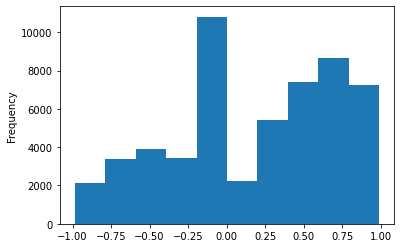

In [108]:
df_tweets.sentiment_vader.plot(kind='hist')

In [23]:
cut_labels = [-1, 0, 1]
cut_bins = [-1, -0.00000001, 0.00000001, 1]
df_tweets['VADER'] = pd.cut(df_tweets.sentiment_vader, bins=cut_bins, labels=cut_labels)
df_tweets['TextBlob'] = pd.cut(df_tweets.polarity, bins=cut_bins, labels=cut_labels)

In [109]:
df_tweets['VADER'].value_counts()

1     31053
-1    14921
0      8708
Name: VADER, dtype: int64

In [24]:
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,retweeted,sentiment_text,subjectivity_score,polarity,sentiment_vader,rate,VADER,TextBlob
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,False,republicans democrats created economic problems,0.200000,0.200000,-0.1779,0,-1,1
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,False,thrilled_back great city charlotte north_carol...,0.483333,0.450000,0.9771,1,1,1
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,True,read letter surveillance court obtained cbs ne...,0.100000,0.100000,0.0000,0,0,1
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,False,unsolicited mail_ballot scam major threat demo...,0.454762,0.029464,-0.9552,0,-1,1
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,True,friendly telling events comey apparent leaking...,0.425000,0.212500,0.4939,1,1,1


In [25]:
df_tweets[['sentiment_text', 'VADER', 'TextBlob']].to_csv('../output/cleaned_dataset.csv', index=False)

In [26]:
final_file = pd.read_csv('../output/cleaned_dataset.csv')
sentiment_map = pd.read_csv('../output/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [27]:
file_weighting = final_file.copy()

In [28]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.sentiment_text)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.sentiment_text)

/Users/darylkow/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [29]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.sentiment_text.split()))

In [30]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

CPU times: user 18.2 s, sys: 408 ms, total: 18.6 s
Wall time: 29.4 s


In [31]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [32]:
replaced_closeness_scores = file_weighting.sentiment_text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [60]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.sentiment_text, file_weighting.VADER]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else -1 for i in replacement_df.sentiment]
replacement_df['prediction'].replace(0,-1, inplace=True)

In [61]:
replacement_df.head()

,sentiment_coeff,tfidf_scores,sentence,sentiment,sentiment_rate,prediction
0,"[1.0004797645770611, -0.9995376825890552, -1.0...","[5.489313225852887, 4.588119597260551, 7.28433...",republicans democrats created economic problems,-1,-6.283310,-1
1,"[1.0034141754865609, -0.999820721067766, -1.00...","[9.076094809943813, 3.1857514113095995, 6.2961...",thrilled_back great city charlotte north_carol...,1,-10.118378,-1
2,"[-1.0009888161233522, -1.0053372540964565, 0.9...","[6.166304966190547, 7.565502732146346, 8.38294...",read letter surveillance court obtained cbs ne...,-1,-8.373921,-1
3,"[-1.000285512291096, 0.9994086307256714, -1.00...","[9.51141288120166, 8.91357588044604, 6.9966532...",unsolicited mail_ballot scam major threat demo...,-1,-3.331732,-1
4,"[-1.0029918101765711, 0.9995721957372308, 1.00...","[8.6134712879957, 7.632642034983974, 7.6898004...",friendly telling events comey apparent leaking...,1,12.106227,1


In [38]:
replacement_df.prediction.value_counts()

1    28005
0    26677
Name: prediction, dtype: int64

<AxesSubplot:>

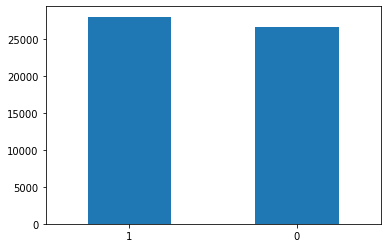

In [39]:
replacement_df.prediction.value_counts().plot(kind='bar',
                                              rot=0)

In [114]:
df_tweets.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,retweeted,sentiment_text,subjectivity_score,polarity,sentiment_vader,rate,VADER,TextBlob
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,False,republicans democrats created economic problems,0.200000,0.200000,-0.1779,0,-1,1
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,False,thrilled_back great city charlotte north_carol...,0.483333,0.450000,0.9771,1,1,1
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f,True,read letter surveillance court obtained cbs ne...,0.100000,0.100000,0.0000,0,0,1
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,False,unsolicited mail_ballot scam major threat demo...,0.454762,0.029464,-0.9552,0,-1,1
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f,True,friendly telling events comey apparent leaking...,0.425000,0.212500,0.4939,1,1,1


In [210]:
df_merged = pd.concat([df_tweets, replacement_df], axis=1)
df_merged.rename(columns={"prediction": "W2V-kNN"}, inplace=True)
df_final = df_merged.iloc[:,[1,10,11,15,16,-1]]

In [211]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56506 entries, 0 to 56570
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   text                54682 non-null  object  
 1   sentiment_text      54682 non-null  object  
 2   subjectivity_score  54682 non-null  float64 
 3   VADER               54682 non-null  category
 4   TextBlob            54430 non-null  category
 5   W2V-kNN             54682 non-null  float64 
dtypes: category(2), float64(2), object(2)
memory usage: 2.3+ MB


In [212]:
df_final.dropna(how='any', inplace=True)
df_final.VADER = df_final.VADER.astype(int)
df_final.TextBlob = df_final.TextBlob.cat.codes - 1
df_final['W2V-kNN'] = df_final['W2V-kNN'].astype(int)

<ipython-input-212-bdbf950dc954>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.dropna(how='any', inplace=True)
/Users/darylkow/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-212-bdbf950dc954>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [213]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52608 entries, 0 to 54681
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   text                52608 non-null  object 
 1   sentiment_text      52608 non-null  object 
 2   subjectivity_score  52608 non-null  float64
 3   VADER               52608 non-null  int64  
 4   TextBlob            52608 non-null  int8   
 5   W2V-kNN             52608 non-null  int64  
dtypes: float64(1), int64(2), int8(1), object(2)
memory usage: 2.5+ MB


In [214]:
df_final['Final'] = (df_final.VADER + df_final.TextBlob + df_final['W2V-kNN'])/3

<ipython-input-214-62f24c0e67c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Final'] = (df_final.VADER + df_final.TextBlob + df_final['W2V-kNN'])/3


In [215]:
cut_labels = [-1, 0, 1]
cut_bins = [-100, -0.00001, 0.00001, 100]
df_final['Final'] = pd.cut(df_final['Final'], bins=cut_bins, labels=cut_labels)

<ipython-input-215-03855659e3aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Final'] = pd.cut(df_final['Final'], bins=cut_bins, labels=cut_labels)


In [216]:
df_final['Final'].value_counts()

1     31934
-1    14439
0      6235
Name: Final, dtype: int64

<AxesSubplot:>

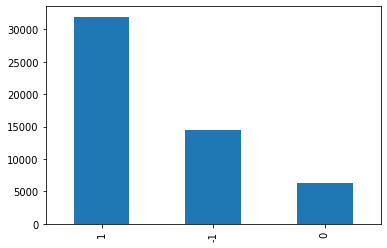

In [217]:
df_final['Final'].value_counts().plot(kind='bar')

In [218]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52608 entries, 0 to 54681
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   text                52608 non-null  object  
 1   sentiment_text      52608 non-null  object  
 2   subjectivity_score  52608 non-null  float64 
 3   VADER               52608 non-null  int64   
 4   TextBlob            52608 non-null  int8    
 5   W2V-kNN             52608 non-null  int64   
 6   Final               52608 non-null  category
dtypes: category(1), float64(1), int64(2), int8(1), object(2)
memory usage: 2.5+ MB


In [219]:
df_final

,text,sentiment_text,subjectivity_score,VADER,TextBlob,W2V-kNN,Final
0,Republicans and Democrats have both created ou...,republicans democrats created economic problems,0.200000,-1,1,-1,-1
1,I was thrilled to be back in the Great city of...,thrilled_back great city charlotte north_carol...,0.483333,1,1,-1,1
2,RT @CBS_Herridge: READ: Letter to surveillance...,read letter surveillance court obtained cbs ne...,0.100000,0,1,-1,0
3,The Unsolicited Mail In Ballot Scam is a major...,unsolicited mail_ballot scam major threat demo...,0.454762,-1,1,-1,-1
4,RT @MZHemingway: Very friendly telling of even...,friendly telling events comey apparent leaking...,0.425000,1,1,1,1
...,...,...,...,...,...,...,...
54677,RT @callme_Chari: @newscomauHQ If he’s anythin...,’ anything like trump congratulations leader l...,0.000000,1,0,-1,0
54678,Congratulations to Scott on a GREAT WIN! https...,congratulations scott great win,0.575000,1,1,1,1
54679,Our courageous and vigilant Armed Forces safeg...,courageous vigilant armed_forces safeguard ble...,0.562500,1,1,-1,1
54680,Consumer Sentiment in the month of May is the ...,consumer sentiment month may highest years nice,1.000000,1,1,-1,1


In [221]:
df_final.to_csv('../output/sentiment_labels.csv')

In [77]:
predicted_classes = replacement_df.prediction
y_test = replacement_df.sentiment

conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.sentiment, replacement_df.prediction))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


,0,1
0,10347,13282
1,14723,16330



 
 Scores


,scores
accuracy,0.487857
precision,0.551466
recall,0.525875
f1,0.538366
